In [1]:
from sqlalchemy import select, func
from sqlalchemy.orm import joinedload
from benchmarklib import BenchmarkDatabase

from rbf import RandomBooleanFunctionTrial, RandomBooleanFunction

A `BenchmarkDatabase` using `benchmarklib` gets initialized with the following, where the sqlite database file is specified.

In [2]:
rbf_db = BenchmarkDatabase("rbf.db", RandomBooleanFunction, RandomBooleanFunctionTrial)

Each benchmark database contains a table of trials which corresponds exactly with a Python class via SQLAlchemy ORM. A trial consists of a single circuit that is run on the quantum computer. Not all trials have their qiskit circuit stored in the local db, so it's a good idea to filter by `_circuit_qpy != None` to just get ones that do have the circuit saved. (The circuit is not saved in the case where compilation failed to produce a circuit; there are also some trials which were created before we started saving circuits and we can retrieve these from IBM via the API if needed). 

Let's examine a few trials. The SQL query is built by SQLAlchemy, and the benchmark database provides `query` as a helpful wrapper around creating a session and executing the query.

In [3]:
trials = rbf_db.query(
    select(RandomBooleanFunctionTrial)
    .where(RandomBooleanFunctionTrial._circuit_qpy != None)
    #.order_by(func.random())  # uncomment for a random sample
    .limit(5)
    .options(joinedload(RandomBooleanFunctionTrial.problem))  # join the problem table so we can access the theoretical expected results of the circuit
)

Now, `_circuit_qpy` is the packed binary blob form of the circuit stored in the database. We access the `circuit` property of a trial to get the circuit as Qiskit QuantumCircuit type.

In [4]:
circuit = trials[0].circuit
type(circuit)

qiskit.circuit.quantumcircuit.QuantumCircuit

In [5]:
from qiskit_aer import AerSimulator
simulator = AerSimulator()

We can examine the circuit visually with `.draw()`.

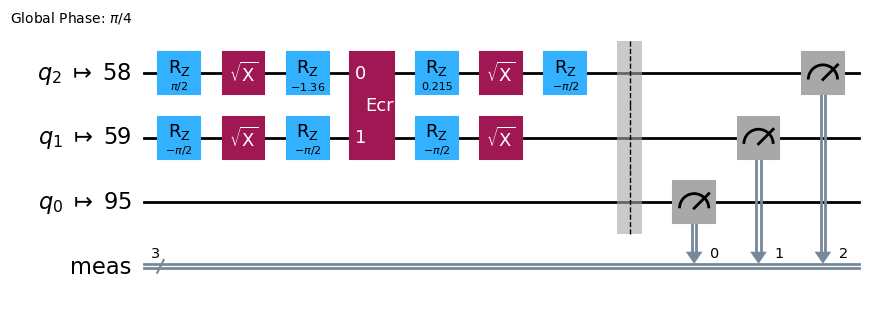

In [6]:
circuit.draw('mpl')

Importantly, we may want to programmatically analyze the circuit topology. The following function from `benchmarklib.utils.circuit` calculates some metrics about the circuit, including a count of the number of each gate that appears in the circuit.

In [7]:
from collections import defaultdict
from typing import Any, Dict
from qiskit import QuantumCircuit

def compute_circuit_metrics(circuit: QuantumCircuit) -> Dict[str, Any]:
    """Compute circuit metrics from the provided circuit"""

    # count number of gates by the number of qubits they act on
    counts = defaultdict(int)
    for inst in circuit.data:
        counts[len(inst.qubits)] += 1

    metrics = {
        "circuit_depth": circuit.depth(),
        "circuit_op_counts": circuit.count_ops(),
        "circuit_num_single_qubit_gates": counts[1],
        "circuit_num_gates": circuit.size() - circuit.count_ops().get("measure", 0),
        "circuit_num_qubits": len({q for instr, qargs, _ in circuit.data for q in qargs}),  # using this instead of circuit.num_qubits to count only qubits actually used
    }
    return metrics

def gates_per_qubit(circuit):
    per_qubit = defaultdict(list)

    # Iterate over instructions in the circuit
    for instruction, qargs, cargs in circuit.data:
        for q in qargs:
            per_qubit[q].append(instruction)

    return per_qubit

for key, value in compute_circuit_metrics(circuit).items():
    print(key,":", value)

for key, value in gates_per_qubit(circuit).items():
    print(key,":", value)

circuit_depth : 8
circuit_op_counts : OrderedDict([('rz', 7), ('sx', 4), ('measure', 3), ('ecr', 1), ('barrier', 1)])
circuit_num_single_qubit_gates : 14
circuit_num_gates : 12
circuit_num_qubits : 3
<Qubit register=(127, "q"), index=58> : [Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.3557751745762365]), Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[]), Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.21502115221866047]), Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.5707963267948966]), Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), Instruction(name='measure', num_qubits=1, num_clbits=1, params=[])]
<Qubit register=(127, "q"), index=59> : [Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.570

/tmp/ipykernel_3853/2066638629.py:18: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  "circuit_num_qubits": len({q for instr, qargs, _ in circuit.data for q in qargs}),  # using this instead of circuit.num_qubits to count only qubits actually used
/tmp/ipykernel_3853/2066638629.py:26: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instruction, qargs, cargs in circuit.data:


In [8]:
g = gates_per_qubit(circuit)
for qubit, instructions in g.items():
    for instr in instructions:
        print(f"Qubit {qubit}: {instr}")

Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966])
Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='sx', num_qubits=1, num_clbits=0, params=[])
Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.3557751745762365])
Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='ecr', num_qubits=2, num_clbits=0, params=[])
Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='rz', num_qubits=1, num_clbits=0, params=[0.21502115221866047])
Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='sx', num_qubits=1, num_clbits=0, params=[])
Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='rz', num_qubits=1, num_clbits=0, params=[-1.5707963267948966])
Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[])
Qubit <Qubit register=(127, "q"), index=58>: Instruction(name='

/tmp/ipykernel_3853/2066638629.py:26: DeprecationWarning: Treating CircuitInstruction as an iterable is deprecated legacy behavior since Qiskit 1.2, and will be removed in Qiskit 3.0. Instead, use the `operation`, `qubits` and `clbits` named attributes.
  for instruction, qargs, cargs in circuit.data:


We are interested in the error rate / success rate of a circuit when it is run on quantum hardware. The circuit in each trial is run many times (usually 1000), and the trial object stores `counts` which is of the form:
```
{
    measured value: number of times measured
}
```

In [9]:
trials[0].counts

{'100': 9825, '010': 31, '101': 23, '110': 40, '000': 81}

In [10]:
total_shots = sum(trials[0].counts.values())
for key, value in trials[0].counts.items():
    print(f"{key}: {value/total_shots:.4f}")

100: 0.9825
010: 0.0031
101: 0.0023
110: 0.0040
000: 0.0081


In some cases, simulation results are also computed and stored in `.simulation_counts`, but this is not always the case because simulation is computationally infeasible for large circuits.

For the rbf benchmark, the kind of circuits created have a single output that should be measured with probability 1 in theory.

In [11]:
trials[0].total_expected_results()

'100'

Trial objects have a `calculate_success_rate` method which uses the compares the measurement results with theoretical expectation.

In [12]:
trials[0].calculate_success_rate()

0.9825

Our goal is to create a model that takes `trial.circuit` and predicts `trial.calculate_success_rate()` before running on hardware.

### Convert to QuEst format

In [13]:
from benchmarklib.databases.backend_properties import get_backend_property_manager
import qiskit
backend_db = get_backend_property_manager()
backend_db.latest("ibm_rensselaer")

<BackendProperty(id=317, backend_name=ibm_rensselaer)>

In [14]:
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from dotenv import load_dotenv, find_dotenv
import os
import qiskit

service = QiskitRuntimeService()
backend = service.backend(name="ibm_rensselaer")

In [17]:
GATE_DICT = {"rz": 0, "x": 1, "sx": 2, "cx": 3, "ecr": 3}  # add ecr for noise reporting
def build_my_noise_dict(prop):  # from torchquantum.examples.quest.utils.circ_dag_converter.py
    mydict = {}
    mydict["qubit"] = {}
    mydict["gate"] = {}
    for i, qubit_prop in enumerate(prop["qubits"]):
        mydict["qubit"][i] = {}
        for item in qubit_prop:
            if item["name"] == "T1":
                mydict["qubit"][i]["T1"] = item["value"]
            elif item["name"] == "T2":
                mydict["qubit"][i]["T2"] = item["value"]
            elif item["name"] == "prob_meas0_prep1":
                mydict["qubit"][i]["prob_meas0_prep1"] = item["value"]
            elif item["name"] == "prob_meas1_prep0":
                mydict["qubit"][i]["prob_meas1_prep0"] = item["value"]
    for gate_prop in prop["gates"]:
        if not gate_prop["gate"] in GATE_DICT:
            continue
        qubit_list = tuple(gate_prop["qubits"])
        if qubit_list not in mydict["gate"]:
            mydict["gate"][qubit_list] = {}
        for item in gate_prop["parameters"]:
            if item["name"] == "gate_error":
                mydict["gate"][qubit_list][gate_prop["gate"]] = item["value"]
    return mydict

properties_dict = backend.properties().to_dict()
noise_properties = build_my_noise_dict(properties_dict)
def convert(trial):
    circuit = trial.circuit
    circuit.remove_final_measurements(inplace=True)  # model does not support the measure gate
    qasm_str = qiskit.qasm2.dumps(circuit)
    return (qasm_str, noise_properties, trial.calculate_success_rate())



In [18]:
raw = list(map(convert, trials))
import pickle
with open("circuits_example.data", "wb") as f:
    pickle.dump(raw, f)